
Eventos sísmicos predichos por año (sum, min, max):
        sum  min  max
year                 
2019  15131    0    1


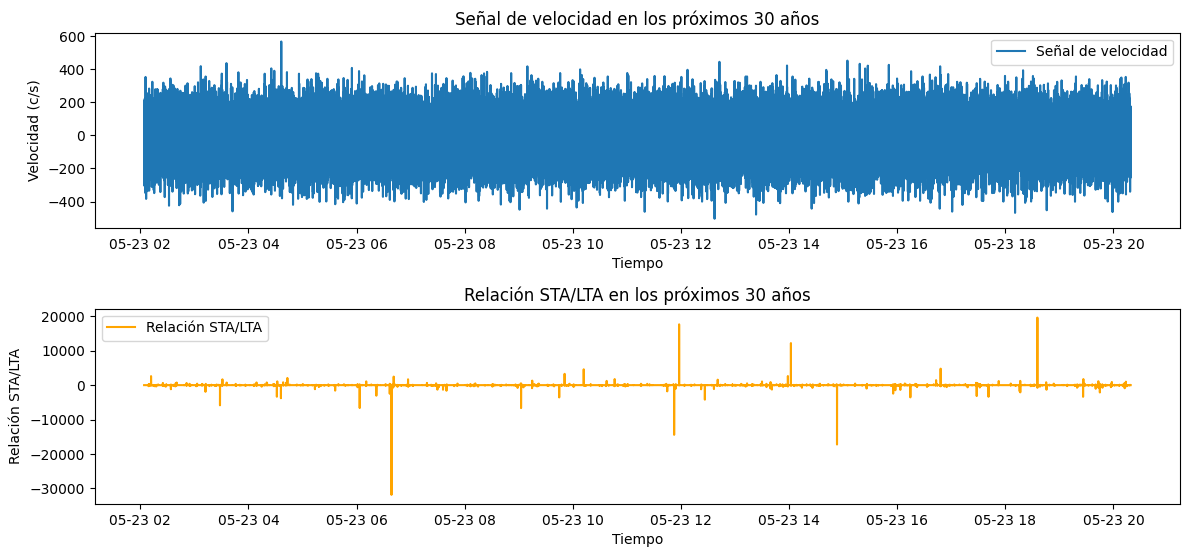

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ruta de la carpeta que contiene los archivos CSV de entrenamiento
folder_path = r'C:\Users\Miguel Angel\Desktop\spaceapp\space_apps_2024_seismic_detection\data\mars\test\data'

# Inicializamos una lista para almacenar los DataFrames
dataframes = []

# Recorremos cada subcarpeta y archivo CSV dentro de la carpeta principal
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        if file_name.endswith('.csv'):
            file_path = os.path.join(root, file_name)
            
            # Cargar solo las columnas necesarias
            df = pd.read_csv(file_path, usecols=['time(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(c/s)'])
            
            # Verificar si el archivo CSV tiene datos
            if not df.empty:
                dataframes.append(df)
            else:
                print(f"Advertencia: El archivo '{file_name}' está vacío.")

# Verificar si se encontraron archivos CSV
if not dataframes:
    print("No se pudo cargar ningún archivo CSV con datos.")
else:
    # Combinar todos los DataFrames en uno solo
    df = pd.concat(dataframes, ignore_index=True)

    # Reducir la cantidad de datos para procesar solo una parte (ej. los primeros 5000 registros)
    df = df.head(5000)

    # Ordenar los datos por tiempo absoluto
    df = df.sort_values('time(%Y-%m-%dT%H:%M:%S.%f)')

    # Convertir la columna de tiempo absoluto a formato de fecha y hora
    df['time(%Y-%m-%dT%H:%M:%S.%f)'] = pd.to_datetime(df['time(%Y-%m-%dT%H:%M:%S.%f)'])

    # ---------------------------------------------
    # Preparación de las características (features)
    # ---------------------------------------------
    # Parámetros para el cálculo de STA/LTA
    sampling_rate = 6  # Número de muestras por segundo (ajústalo según tus datos)
    sta_window = 1 * sampling_rate  # Ventana corta de 1 segundo
    lta_window = 10 * sampling_rate  # Ventana larga de 10 segundos

    # Calcular la media móvil (STA y LTA)
    df['sta'] = df['velocity(c/s)'].rolling(window=sta_window, min_periods=1).mean()
    df['lta'] = df['velocity(c/s)'].rolling(window=lta_window, min_periods=1).mean()

    # Relación STA/LTA, evitando división por cero
    df['sta_lta_ratio'] = df['sta'] / df['lta'].replace(0, np.nan)

    # Extraer características adicionales
    df['velocity_change'] = df['velocity(c/s)'].diff()  # Cambio en la velocidad
    df['time_delta'] = df['time(%Y-%m-%dT%H:%M:%S.%f)'].diff().dt.total_seconds()  # Tiempo entre muestras

    # ---------------------------------------------
    # Definir las etiquetas (target)
    # ---------------------------------------------
    # Asumimos que un evento sísmico ocurre cuando STA/LTA supera un umbral
    threshold = 3
    df['event'] = (df['sta_lta_ratio'] > threshold).astype(int)

    # Eliminar solo las filas donde las columnas críticas tienen NaN
    df = df.dropna(subset=['sta_lta_ratio', 'velocity_change', 'time_delta'])

    # Seleccionar características para el modelo
    features = ['velocity(c/s)', 'sta_lta_ratio', 'velocity_change', 'time_delta']
    X = df[features]
    y = df['event']  # Etiqueta: si ocurrió o no un evento sísmico

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ---------------------------------------------
    # Entrenar el modelo de Random Forest
    # ---------------------------------------------
    # Reducir el número de estimadores para acelerar el entrenamiento
    model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)

    # ---------------------------------------------
    # Simulación de eventos sísmicos a 30 años
    # ---------------------------------------------
    last_time = df['time(%Y-%m-%dT%H:%M:%S.%f)'].max()

    # Crear datos simulados para los próximos 30 años
    future_times = pd.date_range(start=last_time, periods=30*365*sampling_rate, freq='S')  # Datos por segundo
    simulated_velocity = np.random.normal(df['velocity(c/s)'].mean(), df['velocity(c/s)'].std(), len(future_times))

    future_df = pd.DataFrame({
        'time_abs': future_times,
        'velocity(c/s)': simulated_velocity
    })

    # Calcular STA/LTA para los datos futuros simulados
    future_df['sta'] = future_df['velocity(c/s)'].rolling(window=sta_window, min_periods=1).mean()
    future_df['lta'] = future_df['velocity(c/s)'].rolling(window=lta_window, min_periods=1).mean()
    future_df['sta_lta_ratio'] = future_df['sta'] / future_df['lta'].replace(0, np.nan)
    future_df['velocity_change'] = future_df['velocity(c/s)'].diff()
    future_df['time_delta'] = future_df['time_abs'].diff().dt.total_seconds()

    # Eliminar valores NaN
    future_df = future_df.dropna()

    # Predecir eventos sísmicos en los datos futuros
    future_X = future_df[['velocity(c/s)', 'sta_lta_ratio', 'velocity_change', 'time_delta']]
    future_df['predicted_event'] = model.predict(future_X)

    # ---------------------------------------------
    # Agrupar los datos por año y mostrar el max y min de las predicciones
    # ---------------------------------------------
    future_df['year'] = future_df['time_abs'].dt.year

    yearly_stats = future_df.groupby('year')['predicted_event'].agg(['sum', 'min', 'max'])

    print("\nEventos sísmicos predichos por año (sum, min, max):")
    print(yearly_stats)

    # ---------------------------------------------
    # Visualización de los eventos predichos y relación STA/LTA
    # ---------------------------------------------
    plt.figure(figsize=(12, 8))

    # Gráfico de la señal de velocidad futura
    plt.subplot(3, 1, 1)
    plt.plot(future_df['time_abs'], future_df['velocity(c/s)'], label="Señal de velocidad")
    plt.title("Señal de velocidad en los próximos 30 años")
    plt.xlabel("Tiempo")
    plt.ylabel("Velocidad (c/s)")
    plt.legend()

    # Gráfico de la relación STA/LTA
    plt.subplot(3, 1, 2)
    plt.plot(future_df['time_abs'], future_df['sta_lta_ratio'], label="Relación STA/LTA", color='orange')
    plt.title("Relación STA/LTA en los próximos 30 años")
    plt.xlabel("Tiempo")
    plt.ylabel("Relación STA/LTA")
    plt.legend()



    plt.tight_layout()
    plt.show()
